### Sentiment analysis using Transformers, NLTK, and WordCloud
Credit: Codes developed with the help of ChatGPT.

Issue Tracker:

- 7/10/23: When running the sentiment analysis scripts, discovered that the sentiment analysis model only reads up to 512 "tokens," which may not necessarily refer to single characters. Longer comments will break the code. Fix: I truncated comment lengths to 500 characters. 
- 7/10/23: Code also broke when analysing correlation, because of "$" and ",". The workaround was to drop rows with unexpected characters, with two options. First option was to replace dropped rows, but this ran the risk of picking up the same comments again. A cleaner solution was to drop rows without replacement. In both scenarios, this meant we would be dropping all values above 1,000, which could impact correlation scores. 

- 8/10/23: Updated sentiment analysis codes, after data was re-cleaned to remove "$" and "," from the price field and make it a float. With this change, no longer need to filter out unexpected characters or drop rows containing values above 1,000 in Python. Code runs faster, can try a larger sample size.

- 9/10/23: Had to update all analysis codes because of sudden error --> AttributeError: 'Engine' object has no attribute 'execute'. Related resources: 
    - https://stackoverflow.com/questions/75316741/attributeerror-engine-object-has-no-attribute-execute-when-trying-to-run-sq
    - https://github.com/dagster-io/dagster/discussions/11881
    - Errors fixed, not sure what was the cause. Could have been an internal conflict resulting from new installs, or perhaps there was an update on SQLAlchemy. Aided by ChatGPT, I implemented the same solution as outlined in the Stack Overflow link.

- 14/10/23: To note the privacy issues resulting from sharing codes with our database connection parameters. Kent has raised the possibility of creating an interface for this. Another improvement to look into -- progress bars for codes that take longer to run: https://towardsdatascience.com/ever-wanted-progress-bars-in-jupyter-bdb3988d9cfc

### Create a SQLAlchemy Engine for connecting to PostgreSQL database

In [8]:
from sqlalchemy import create_engine

# Define connection parameters
db_params = {
    'dbname': 'airbnb',
    'user': 'postgres',
    'password': 'password',
    'host': 'localhost', 
    'port': 5432
}

# Create connection URL
connection_url = 'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}'.format(**db_params)

# Establish connection
engine = create_engine(connection_url)

### Test the TextBlob library

TextBlob was created by Steven Loria, a software developer known for his work on various Python libraries. The project is open-source, and its official page is here: https://textblob.readthedocs.io/en/dev/ 

TextBlob provides a simple API for common natural language processing (NLP) tasks, but it's not always the best tool for sentiment analysis. Example:

In [9]:
from textblob import TextBlob

TextBlob("I don't like this movie.").sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

Checking if TextBlob results can be improved by importing PatternAnalyzer — no, results are the same. Not recommended for our project use case.

In [10]:
from textblob.sentiments import PatternAnalyzer

blob = TextBlob("I don't like this movie.", analyzer=PatternAnalyzer())
blob.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

### Test the Pipeline function from the Transformers library

The Pipeline function from the Transformers library is an easy-to-use API for many common tasks in Natural Language Processing (NLP). This function abstracts away much of the underlying complexity, allowing users to perform tasks like sentiment analysis with just a few lines of code. The Transformers library was created by the company Hugging Face, which specialises in NLP tools.

I used the model "DistilBERT base uncased finetuned SST-2," as recommended by ChatGPT. It is a pre-trained model provided by the Transformers library, and it is accessed and utilised through the Pipeline function. 

Below is a simple sentiment analysis test using this model. One can also test the model on its official page: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

The model generates a positive/negative sentiment label, as well as a confidence-level score. A potential issue is the model's runtime, and it can be difficult to find help on forums such as Stack Overflow. (See example: https://stackoverflow.com/questions/72215217/huggingface-distilbert-base-uncased-finetuned-sst-2-english-runs-out-of-ram-with.) This is where ChatGPT can fill the gap to recommend solutions.

Notes:
- The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. (Source: https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
- Broadly, BERT considers the entire context of a sentence or sequence of words together, rather than analysing each word in isolation. This approach allows the model to understand the full context and nuanced meaning of words based on their surrounding text, leading to more accurate representations and predictions, especially in tasks like sentiment analysis.
- To be clear, BERT was not created by Hugging Face -- it is a model developed by researchers at Google. Hugging Face is well-known for its Transformers library in Python, which provides a wide variety of pre-trained models, including BERT, and makes them easily accessible and usable. This integration by Hugging Face has simplified the process of implementing these complex models for developers and researchers.

In [83]:
# !pip install transformers
# !pip install torch

from transformers import pipeline

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)
result1 = sentiment_pipeline("I don't like this movie.")
result2 = sentiment_pipeline("This movie is pretty bad.")
result3 = sentiment_pipeline("This movie is ok.")
result4 = sentiment_pipeline("This movie is great.")

print(result1)
print(result2)
print(result3)
print(result4)

[{'label': 'NEGATIVE', 'score': 0.9938645958900452}]
[{'label': 'NEGATIVE', 'score': 0.9997928738594055}]
[{'label': 'POSITIVE', 'score': 0.999839186668396}]
[{'label': 'POSITIVE', 'score': 0.9998801946640015}]


#### Checking case insensitivity for the "DistilBERT base uncased finetuned SST-2" model
Because this model operates 'under the hood,' it is challenging to know for sure that it will treat all text as lowercase. However, this is the assumption that I will make, based on the fact that there is a "cased" version of the model where the documentation explicitly states that it is case sensitive:
https://huggingface.co/bert-base-cased

In the documentation for the "uncased" model, it is stated that during preprocessing, the texts are lowercased and tokenised using WordPiece and a vocabulary size of 30,000. (WordPiece is a method of tokenisation that BERT uses, which breaks words into smaller, more manageable pieces that the model can understand. For example, the word "embeddings" might be broken down into smaller tokens like "em", "bed", "ding", and "s". This allows the model to handle words that weren't in the original vocabulary, and reduces the vocabulary size that the model needs to learn.)

Based on the model's name and the preprocessing information, I will assume that no additional steps are needed to lowercase the text for this model. Related resources:
- https://huggingface.co/bert-base-uncased
- https://stackoverflow.com/questions/62466514/shall-we-lower-case-input-data-for-pre-training-a-bert-uncased-model-using-hug

Below is a simple test to confirm that sentences receive the same score regardless of casing.

In [6]:
from transformers import pipeline

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Test sentences with varying cases
sentences = [
    "I don't like this movie.",  # original
    "i don't like this movie.",  # all lower case
    "I DON'T LIKE THIS MOVIE.",  # all upper case
    "This movie is great.",  # original
    "this movie is great.",  # all lower case
    "THIS MOVIE IS GREAT.",  # all upper case
]

# Analyze sentiment for each sentence
for sentence in sentences:
    result = sentiment_pipeline(sentence)
    print(f"Input: {sentence}\nSentiment: {result}\n")

Input: I don't like this movie.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9938645958900452}]

Input: i don't like this movie.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9938645958900452}]

Input: I DON'T LIKE THIS MOVIE.
Sentiment: [{'label': 'NEGATIVE', 'score': 0.9938645958900452}]

Input: This movie is great.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998801946640015}]

Input: this movie is great.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998801946640015}]

Input: THIS MOVIE IS GREAT.
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998801946640015}]



### Question 1: For each city, are reviews more positive or negative?
#### Answer: All cities have mostly positive reviews, i.e. more than half their reviews are positive.

Notes: 
- In the code below, scalar() is a way to directly retrieve a single value -- here, the row count -- avoiding manual extraction (e.g. indexing) from more complex data structures. This count assesses whether row quantity is more than a set threshold, and triggers a switch to random sample analysis if exceeded.
- For analysis, each comment is checked for length and truncated if it exceeds the maximum length. Then, the sentiment of each comment is analysed using the selected BERT model. Only the sentiment label (Positive/Negative) is retrieved from the analysis result and added as a new column to the DataFrame. There is no retrieval or storage of sentiment scores. Based on the count of Positive sentiment labels, the overall sentiment for the comments in each table is determined and printed out, indicating whether sentiments are 'Mostly Positive,' 'Mostly Negative,' or 'Neutral' (same number of positive and negative comments).
- For a sample size of 250 per city, the runtime is about 3 minutes. (Result: Mostly Positive for all cities) 
- For a sample size of 1,000 per city, the runtime is about 9.5 minutes. (Result: Mostly Positive for all cities)
- On 9/10/23, I encountered an error in my previously functional code, specifically 'AttributeError: 'Engine' object has no attribute 'execute''. This indicated that the code attempted to invoke 'execute' directly on an SQLAlchemy 'Engine' object, where this method doesn't exist. The solution was to modify the code to call 'execute' on a 'Connection' object obtained from the engine, rather than the engine itself. Additionally, I implemented the use of SQLAlchemy's text function to handle raw SQL queries. This function converts a plain query string into an object that SQLAlchemy recognises as a SQL expression, ensuring proper interaction with the database.

In [12]:
import pandas as pd
from sqlalchemy import create_engine, text
from transformers import pipeline

# Initialize sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

THRESHOLD = 10000
SAMPLE_SIZE = 1000

def is_comment_too_long(comment, max_length=500):
    return len(comment) > max_length

def get_sentiment(comment):
    sentiment_result = sentiment_analysis(comment)
    return sentiment_result[0]['label']

table_names = ["amsterdam_review", "london_review", "new_york_review", "paris_review", "rome_review"]

for table_name in table_names:
    with engine.connect() as connection:
        # Determine if sampling is needed
        table_size_query = text(f"SELECT COUNT(*) FROM {table_name}")
        table_size = connection.execute(table_size_query).scalar()
        
        if table_size > THRESHOLD:
            query_text = f"SELECT comments FROM {table_name} ORDER BY RANDOM() LIMIT {SAMPLE_SIZE}"
        else:
            query_text = f"SELECT comments FROM {table_name}"

        query = text(query_text)
        comments_df = pd.read_sql(query, connection)
        comments_df['comments'] = comments_df['comments'].apply(lambda x: x[:500] if is_comment_too_long(x) else x)

        # Analyze sentiments
        comments_df['sentiment'] = comments_df['comments'].apply(get_sentiment)

        # Determine overall sentiment
        positive_count = comments_df['sentiment'].value_counts().get('POSITIVE', 0)
        overall_sentiment = "Neutral"
        if positive_count > len(comments_df) / 2:
            overall_sentiment = "Mostly Positive"
        elif positive_count < len(comments_df) / 2:
            overall_sentiment = "Mostly Negative"

    print(f"Table {table_name} ({'sample' if table_size > THRESHOLD else 'full'}) is {overall_sentiment}")

Table amsterdam_review (sample) is Mostly Positive
Table london_review (sample) is Mostly Positive
Table new_york_review (sample) is Mostly Positive
Table paris_review (sample) is Mostly Positive
Table rome_review (sample) is Mostly Positive


### Question 2: What are the most frequent words for the reviews?

Notes on NLTK:
- NLTK, or the Natural Language Toolkit, is a well-known platform for building Python programs to work with human language data. It was created by Steven Bird and Edward Loper in the Department of Computer and Information Science at the University of Pennsylvania. 
- The NLTK library is famous for offering simple ways to access more than 50 collections of text data and word-related resources, coupled with tools for organising text, breaking it into digestible pieces, getting to the roots of words, labelling their parts of speech, analysing sentence structure, and understanding word meanings. It's widely used in educational and business settings: https://www.nltk.org/
- For NLTK, text must be converted to lowercase during preprocessing because this library's tools are case sensitive: https://becominghuman.ai/nlp-for-beginners-using-nltk-f58ec22005cd

Notes on WordCloud:
- The Wordcloud library generates an image of the word cloud, but it doesn't display the image by itself. Matplotlib is used to display the word cloud image in a window. The plt.imshow() function is responsible for rendering the image data (the word cloud in this case) to the plotting area.
- The Wordcloud library's primary responsibility is to generate an image of the word cloud, not to manage the complex functionalities associated with rendering images in a graphical user interface (GUI). This design adheres to a principle in software development known as "separation of concerns," which dictates that a software component should focus on one specific task or role.

In [13]:
# Required downloads
# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install pillow
# !pip install sqlalchemy pandas nltk wordcloud matplotlib

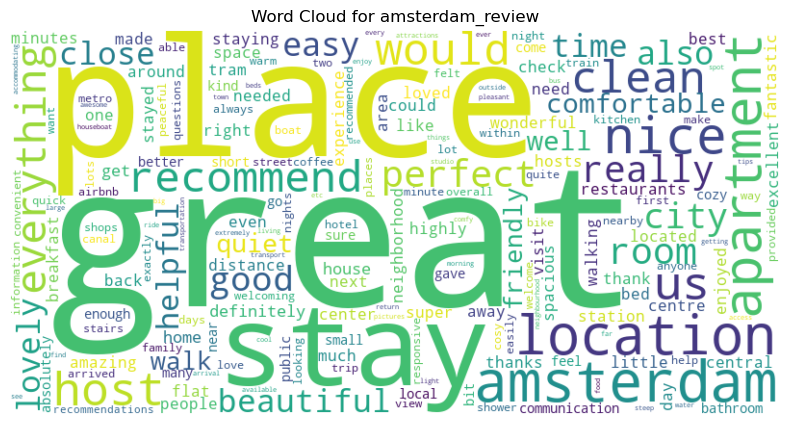

Top words for table amsterdam_review:
great: 532
place: 484
stay: 466
amsterdam: 386
location: 356
apartment: 332
nice: 310
us: 265
host: 259
clean: 234
would: 232
recommend: 219
everything: 207
perfect: 195
room: 187
really: 187
city: 179
good: 173
also: 153
easy: 151
time: 141
lovely: 141
beautiful: 139
close: 139
helpful: 133
comfortable: 132
well: 129
quiet: 124
friendly: 114
walk: 111
definitely: 109
get: 109
home: 108
house: 104
back: 97
amazing: 96
highly: 95
even: 95
area: 93
wonderful: 93
loved: 91
center: 89
staying: 85
central: 85
tram: 80
located: 78
could: 78
neighborhood: 77
needed: 76
station: 76




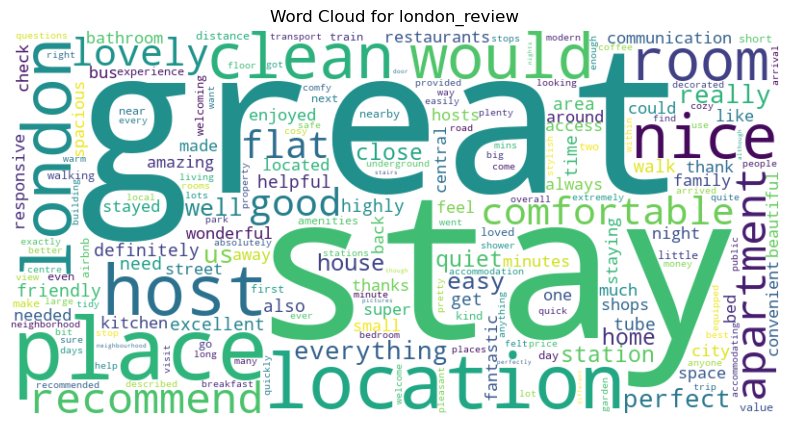

Top words for table london_review:
great: 542
stay: 535
place: 379
location: 349
host: 291
london: 276
clean: 240
would: 233
nice: 223
room: 204
recommend: 197
apartment: 196
lovely: 183
good: 179
comfortable: 178
flat: 170
everything: 160
us: 157
really: 157
perfect: 151
well: 145
easy: 143
house: 130
close: 115
home: 113
station: 110
quiet: 108
definitely: 106
tube: 106
area: 105
helpful: 102
walk: 100
time: 97
friendly: 94
also: 93
highly: 89
excellent: 88
get: 86
need: 86
communication: 78
could: 78
amazing: 74
enjoyed: 72
restaurants: 71
central: 70
one: 69
hosts: 68
needed: 67
wonderful: 67
thank: 67




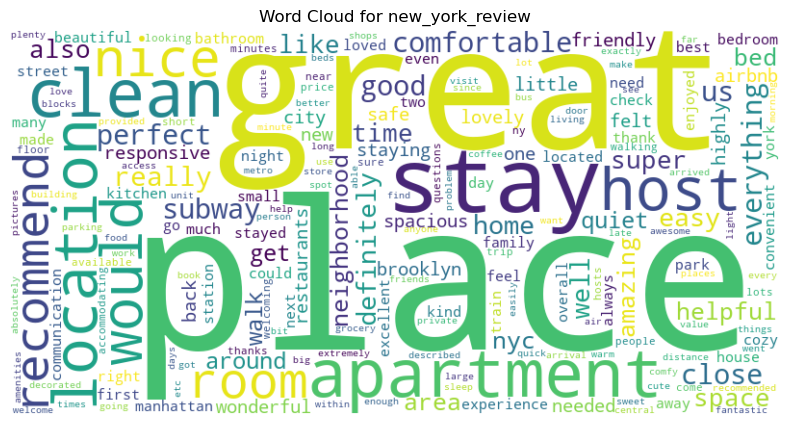

Top words for table new_york_review:
place: 574
great: 565
stay: 531
apartment: 352
clean: 351
location: 295
host: 276
would: 261
nice: 222
room: 187
recommend: 179
comfortable: 169
subway: 164
everything: 162
close: 158
good: 155
us: 154
perfect: 151
really: 144
easy: 137
definitely: 137
well: 135
home: 134
also: 127
space: 126
like: 124
time: 124
super: 120
neighborhood: 109
nyc: 108
helpful: 104
bed: 102
area: 99
amazing: 97
walk: 92
around: 92
get: 91
quiet: 91
responsive: 90
one: 89
needed: 87
felt: 85
spacious: 84
friendly: 82
highly: 82
airbnb: 82
brooklyn: 81
new: 80
city: 80
restaurants: 79




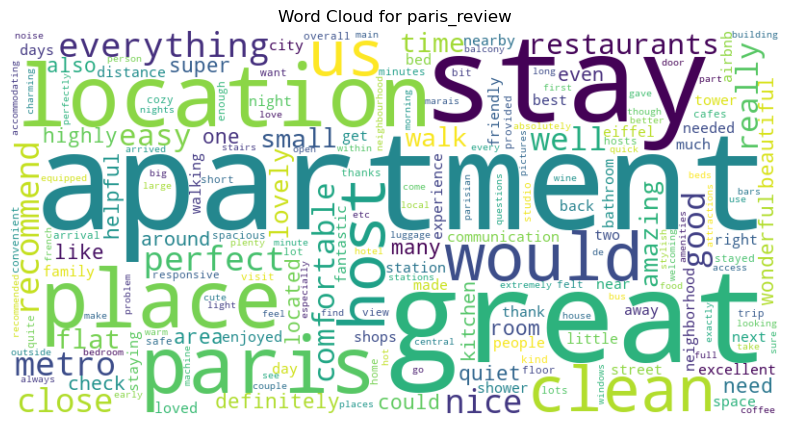

Top words for table paris_review:
apartment: 642
great: 574
stay: 498
location: 477
place: 417
paris: 393
would: 267
host: 246
us: 245
clean: 235
everything: 232
perfect: 225
metro: 224
recommend: 212
nice: 211
close: 207
well: 197
good: 196
easy: 173
really: 172
comfortable: 167
restaurants: 155
time: 137
flat: 136
walk: 130
small: 129
lovely: 123
amazing: 121
definitely: 121
also: 120
one: 118
need: 114
area: 113
helpful: 113
wonderful: 111
located: 110
beautiful: 107
like: 104
highly: 102
room: 101
quiet: 100
could: 98
many: 96
super: 94
check: 89
even: 87
kitchen: 85
around: 84
communication: 84
get: 84




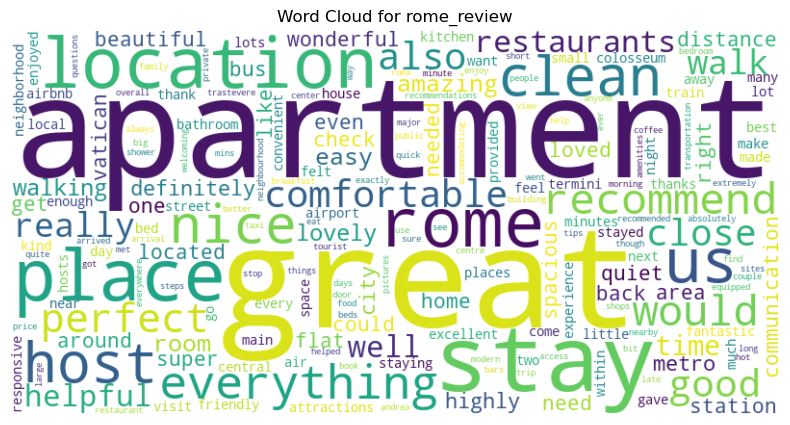

Top words for table rome_review:
apartment: 629
great: 628
stay: 474
place: 461
location: 446
rome: 425
us: 347
host: 284
clean: 275
nice: 255
everything: 241
recommend: 232
would: 224
perfect: 213
good: 190
also: 182
comfortable: 182
close: 173
really: 167
walk: 167
restaurants: 158
helpful: 152
well: 151
time: 131
amazing: 129
room: 129
easy: 127
walking: 123
lovely: 119
definitely: 118
highly: 114
metro: 111
city: 110
beautiful: 103
area: 103
get: 100
wonderful: 100
even: 99
need: 98
distance: 97
like: 96
flat: 94
located: 92
quiet: 92
around: 91
check: 88
station: 86
communication: 85
one: 85
super: 84




In [14]:
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
from sqlalchemy import create_engine, text
from wordcloud import WordCloud

table_names = ["amsterdam_review", "london_review", "new_york_review", "paris_review", "rome_review"]

THRESHOLD = 10000  # If table size is more than this, use random sampling
SAMPLE_SIZE = 1000  # Size of the random sample if sampling is used

# Stop words are common words (e.g., 'the', 'is', 'in')
# Ideally filtered out during text preprocessing and analysis
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Preprocess the text: tokenize, lowercase, remove stopwords."""
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Fetch, preprocess, and analyse each table
for table_name in table_names:
    with engine.connect() as connection:
        # Determine the size of the table
        table_size_query = text(f"SELECT COUNT(*) FROM {table_name}")
        table_size = connection.execute(table_size_query).scalar()
        
        if table_size > THRESHOLD:
            # Fetch a random sample from the table
            query_text = f"SELECT comments FROM {table_name} ORDER BY RANDOM() LIMIT {SAMPLE_SIZE}"
        else:
            # Fetch the entire table
            query_text = f"SELECT comments FROM {table_name}"

        query = text(query_text)
        comments_df = pd.read_sql(query, connection)

        # Drop NaN values and preprocess the text
        comments = comments_df["comments"].dropna().apply(preprocess_text)
    
        # Count word frequencies
        word_freq = Counter(word for comment in comments for word in comment)
    
        # Generate a word cloud from the word frequencies
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear') # Smoothen the image when resizing
        plt.axis('off') # Turn off axis labels and ticks/axis markings
        plt.title(f"Word Cloud for {table_name}")
        plt.show()
    
        # Get the top words
        top_words = word_freq.most_common(50)  # Adjust as desired
    
        print(f"Top words for table {table_name}:")
        for word, freq in top_words:
            print(f"{word}: {freq}")
        print("\n")

### Question 3: Is there a correlation between price and review sentiment?

#### Answer: No correlation.

In [15]:
# Using newly cleaned data on 9/10/23
# Checking the dataype of the price variable 

from sqlalchemy import create_engine, text

table_name = 'amsterdam_listing'
column_name = 'price'

# Build the SQL query using the text construct
query = text(f"SELECT data_type FROM information_schema.columns WHERE table_name = '{table_name}' AND column_name = '{column_name}';")

# Use a connection object to execute the query
with engine.connect() as connection:
    data_type = connection.execute(query).scalar()
    print(data_type)

double precision


### Calculating correlation

Below, the corr() method from pandas is used to compute the Pearson correlation coefficient between the 'sentiment_score' and 'price' columns of the DataFrame df. This method abstracts all the details of the formula and returns the coefficient value directly.

The Pearson correlation coefficient, often denoted as r, measures the strength and direction of the linear relationship between two variables. It can take on values between -1 and 1:

- A value closer to +1 implies a strong positive correlation: as one variable increases, the other also tends to increase.
- A value closer to -1 implies a strong negative correlation: as one variable increases, the other tends to decrease.
- A value closer to 0 implies little to no linear correlation between the variables.

In a simplified manner, the Pearson correlation evaluates if, as one variable increases, the other variable tends to also increase (positive correlation) or decrease (negative correlation). 

Notes: 

- In the code below, comments are truncated at 500 characters to meet the model's input requirements. (But may still encounter errors.) Each comment's sentiment is then analysed, yielding a tuple that contains both the sentiment label (Positive/Negative) and the corresponding confidence score. These tuples are unpacked using the zip function, which separates them into two individual lists -- one for the sentiment labels and another for the sentiment scores. These lists are assigned as new columns in the DataFrame, to compute the correlation between sentiment scores and prices.

In [17]:
"""
May still get this error even though comments are truncated at 500. 
Adjust to 490 if necessary.
Error message: Token indices sequence length is longer than the specified 
maximum sequence length for this model (564 > 512). 
Running this sequence through the model will result in indexing errors
"""

import pandas as pd
from sqlalchemy import create_engine, text
from transformers import pipeline

# Engine initialized in [25] 
# Initialize sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def fetch_and_analyze_data(city_name, SAMPLE_SIZE=250):
    # Determine the table name
    table_name = f"{city_name}_listing"

    def truncate_long_comments(comment):
        return comment[:500] if len(comment) > 500 else comment

    def analyze_sentiment_single(comment):
        result = sentiment_analysis(comment)
        return result[0]['label'], result[0]['score']

    combined_query_text = text(f"""
    SELECT L.id, L.price, R.comments
    FROM {table_name} AS L
    JOIN {table_name.replace('listing', 'review')} AS R ON L.id = R.listing_id
    ORDER BY RANDOM() 
    LIMIT {SAMPLE_SIZE}
    """)
    
    with engine.connect() as connection:
        df = pd.read_sql(combined_query_text, connection)

        df['comments'] = df['comments'].apply(truncate_long_comments)
        sentiment_data = df['comments'].apply(analyze_sentiment_single)
        df['sentiment_label'], df['sentiment_score'] = zip(*sentiment_data)
    
    return df

"""
Print the correlation in a formatted string. 
2f means two decimal places, floating point number
"""

def print_correlation(df, city_name):
    correlation = df['sentiment_score'].corr(df['price'])
    print(f"Correlation between sentiment score and price in {city_name}: {correlation:.2f}")

# Call the functions
cities = ['amsterdam', 'london', 'new_york', 'paris', 'rome']

for city in cities:
    city_df = fetch_and_analyze_data(city)
    print_correlation(city_df, city)

Correlation between sentiment score and price in amsterdam: -0.01
Correlation between sentiment score and price in london: -0.03
Correlation between sentiment score and price in new_york: -0.05
Correlation between sentiment score and price in paris: -0.01
Correlation between sentiment score and price in rome: 0.03


In [18]:
# Check dataframe info. This shows the last data set processed (Rome).

city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               250 non-null    int64  
 1   price            250 non-null    float64
 2   comments         250 non-null    object 
 3   sentiment_label  250 non-null    object 
 4   sentiment_score  250 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 9.9+ KB


### Calculating correlation between price > 500 and review sentiment 

Notes: 

- Also increased the sample size, to see if this might increase correlation.

In [92]:
from sqlalchemy import create_engine, text
from transformers import pipeline
import pandas as pd

# Engine initialized in [25] 
# Initialize sentiment analysis pipeline
sentiment_analysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def fetch_and_analyze_data(city_name, SAMPLE_SIZE=500, MIN_PRICE=500):
    table_name = f"{city_name}_listing"

    def truncate_long_comments(comment):
        return comment[:500] if len(comment) > 500 else comment

    def analyze_sentiment_single(comment):
        result = sentiment_analysis(comment)
        return result[0]['label'], result[0]['score']

    combined_query_text = text(f"""
    SELECT L.id, L.price, R.comments
    FROM {table_name} AS L
    JOIN {table_name.replace('listing', 'review')} AS R ON L.id = R.listing_id
    WHERE L.price > {MIN_PRICE}
    ORDER BY RANDOM() 
    LIMIT {SAMPLE_SIZE}
    """)

    with engine.connect() as connection:
        df = pd.read_sql(combined_query_text, connection)

    df['comments'] = df['comments'].apply(truncate_long_comments)
    sentiment_data = df['comments'].apply(analyze_sentiment_single)
    df['sentiment_label'], df['sentiment_score'] = zip(*sentiment_data)

    return df

def print_correlation(df, city_name):
    if len(df) < 2 or df['sentiment_score'].nunique() < 2:
        print(f"Not enough unique data for {city_name} to compute correlation.")
        return

    correlation = df['sentiment_score'].corr(df['price'])
    print(f"Correlation between sentiment score and price in {city_name}: {correlation:.2f}")

cities = ['amsterdam', 'london', 'new_york', 'paris', 'rome']

for city in cities:
    city_df = fetch_and_analyze_data(city)
    print_correlation(city_df, city)

Correlation between sentiment score and price in amsterdam: 0.02
Correlation between sentiment score and price in london: -0.00
Correlation between sentiment score and price in new_york: -0.03
Correlation between sentiment score and price in paris: 0.01
Correlation between sentiment score and price in rome: -0.05


### Question 4: Which city has the highest review scores (in general, as well as for specific areas?)

Create a table of the 5 cities, showing the average score in each review category.

#### Answer: Amsterdam has the highest average review scores across the board.

In [93]:
import pandas as pd
from sqlalchemy import create_engine, text

cities = ['amsterdam', 'london', 'new_york', 'paris', 'rome']
review_fields = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]

all_results = []

for city in cities:
    city_results = {'city': city}
    
    with engine.connect() as connection:
        for field in review_fields:
            query_text = text(f"SELECT AVG({field}) AS avg_{field} FROM {city}_listing;")
            result = connection.execute(query_text).fetchone()
            
            city_results[field] = result[0]  # Get the average value from the result
        
        all_results.append(city_results)

df = pd.DataFrame(all_results)
print(df)

        city  review_scores_rating  review_scores_accuracy  \
0  amsterdam              4.839410                4.859681   
1     london              4.638501                4.748110   
2   new_york              4.661179                4.768669   
3      paris              4.664794                4.768388   
4       rome              4.712835                4.775929   

   review_scores_cleanliness  review_scores_checkin  \
0                   4.777469               4.892643   
1                   4.657567               4.805120   
2                   4.645155               4.834884   
3                   4.625086               4.808709   
4                   4.743322               4.837907   

   review_scores_communication  review_scores_location  review_scores_value  
0                     4.910832                4.798282             4.652868  
1                     4.827293                4.740315             4.631959  
2                     4.832422                4.750294        

In [79]:
# Exploring more ways to visualise the above table
# !pip install PrettyTable

from prettytable import PrettyTable
table = PrettyTable(list(df.columns))
for row in df.itertuples():
    table.add_row(row[1:])
print(table)

+-----------+----------------------+------------------------+---------------------------+-----------------------+-----------------------------+------------------------+---------------------+
|    city   | review_scores_rating | review_scores_accuracy | review_scores_cleanliness | review_scores_checkin | review_scores_communication | review_scores_location | review_scores_value |
+-----------+----------------------+------------------------+---------------------------+-----------------------+-----------------------------+------------------------+---------------------+
| amsterdam |  4.8394096058719995  |   4.859680664218386    |     4.777469263930994     |   4.892642503592485   |      4.910831869710974      |   4.798281973495096    |  4.652867635318495  |
|   london  |  4.638501128899919   |   4.7481098369608326   |     4.657566752463489     |   4.805120459985523   |      4.827292869402484      |   4.740315353992753    |  4.631958524146602  |
|  new_york |  4.661179024716139   |   4.7686

### Visualise the findings
Seaborn is known for its visually appealing default style and pleasing colour palettes: https://www.linkedin.com/pulse/battle-visuals-matplotlib-vs-seaborn-data-science-adeoluwa-atanda

### Seaborn or Matplotlib?
Seaborn is built on top of Matplotlib, and provides a high-level interface for drawing attractive and informative statistical graphics. 

However, Seaborn does not have dedicated functions for every aspect of plot customisation. For fine-tuning aspects of a plot -- such as title, x-axis labels, and y-axis labels -- one would fall back on Matplotlib commands. This is because Seaborn's functionality is designed to fit into the Matplotlib ecosystem, and to interact seamlessly with Matplotlib's features. (In other words, when you create a plot using Seaborn, it actually uses Matplotlib to draw those plots.)

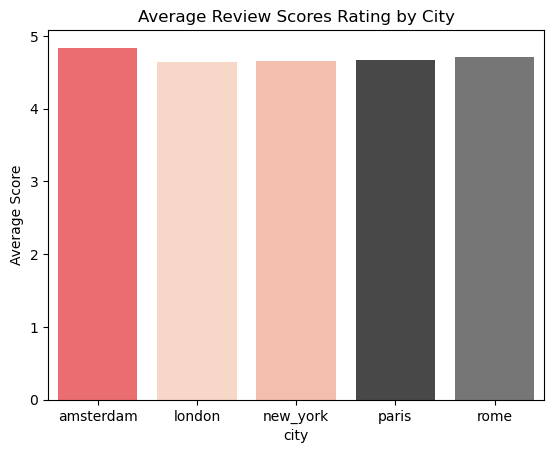

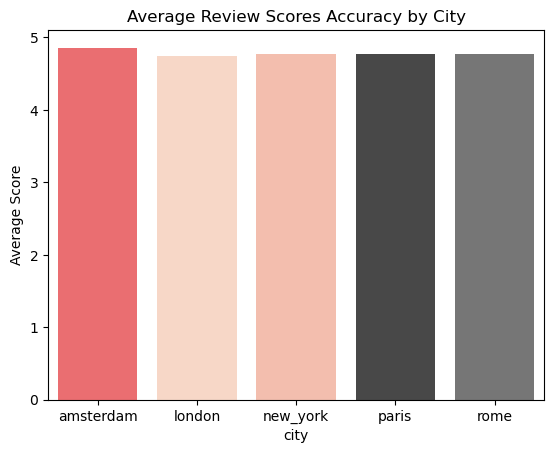

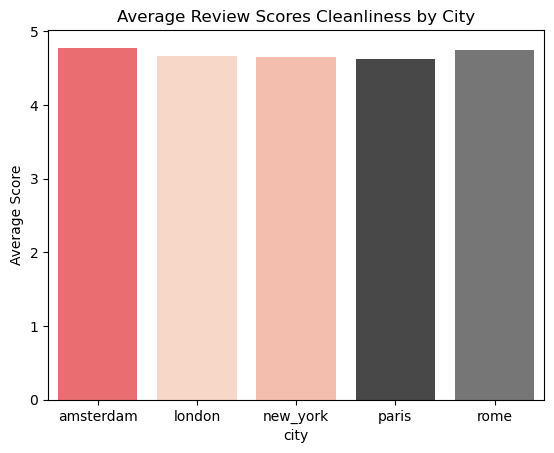

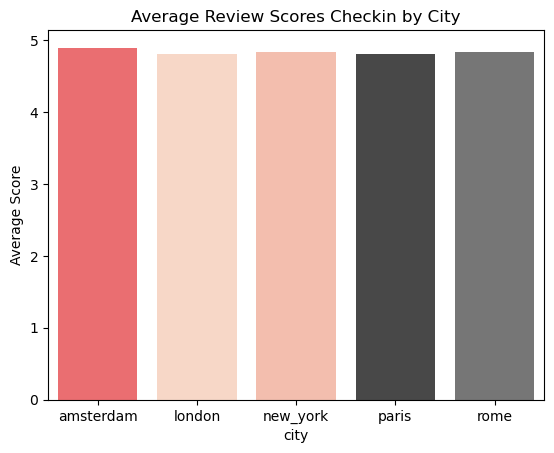

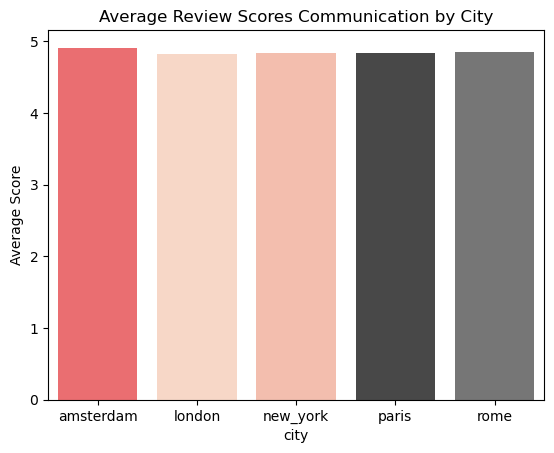

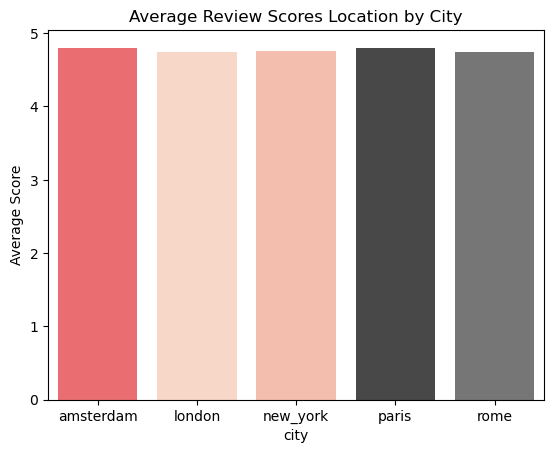

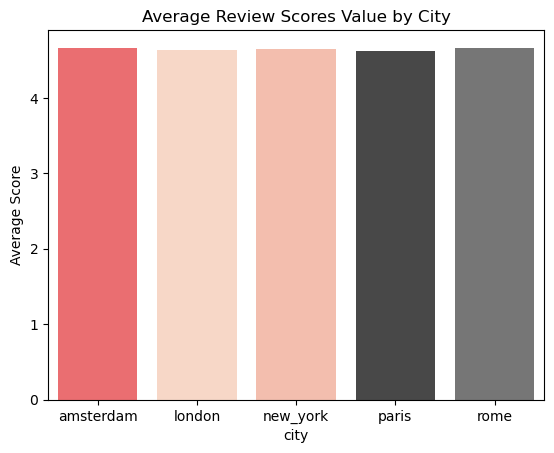

In [73]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt

for field in review_fields:
    with engine.connect() as connection:
     
        # Define a custom color palette using a list of colors
        custom_palette = ["#FF595E", "#FFD4BF", "#FFB8A2", "#484848", "#767676"]
    
        sns.barplot(x='city', y=field, data=df, palette=custom_palette)
        plt.title(f"Average {field.replace('_', ' ').title()} by City")
        plt.ylabel("Average Score")
        plt.show()

### Why does Amsterdam have higher reviews?

Checking on the number of review score ratings by country -- Amsterdam has significantly less ratings than the other cities, even though it's a Top 5 destination city. As its data set is smaller, one way to look at this is that there is a lower chance of negative reviews. Related resources:

- https://www.inc.com/andrew-thomas/the-hidden-ratio-that-could-make-or-break-your-company.html
- https://www.nationalstrategic.com/why-would-they-write-that-the-psychology-of-customer-reviews/

As for why the Amsterdam data set is much smaller -- it is a smaller city, with a smaller population. For instance, it has a population of about 1 million, compared to London's 9 million:

https://dutchreview.com/traveling/cities/a-comparison-of-two-capitals-amsterdam-versus-london/

Suggestion for future improvement: to give more context to such results, we may want to include data such as population and land size for each city.

In [100]:
import pandas as pd
from sqlalchemy import create_engine, text

cities = ['amsterdam', 'london', 'new_york', 'paris', 'rome']
reviews = ['review_scores_rating']

all_results = []

for city in cities:
    city_results = {'city': city}
    
    with engine.connect() as connection:
        for field in reviews:
            query_text = text(f"SELECT COUNT(*) FROM {city}_listing;")
                        
            result = connection.execute(query_text).fetchone()
            
            city_results[field] = result[0]
        
        all_results.append(city_results)
    
total = pd.DataFrame(all_results)
print(total.to_string(index=False))

     city  review_scores_rating
amsterdam                  6866
   london                 50152
 new_york                 23091
    paris                 47560
     rome                 19502


### Used Tableau Public to answer our remaining data questions: https://public.tableau.com/app/profile/evelyn.tan.rogers/viz/AirbnbHostID/HostLocation